# Step1: Source injection

In [43]:
import lib.butler as btl
import lib.tools as tl
import lib.stamp as stp
import lib.inject as inj
import lib.visual as vis

from astropy.io import fits
import os

In [44]:
%matplotlib inline

In [45]:
os.makedirs(tl.CATALOG_FOLDER, exist_ok=True)
os.makedirs(tl.FIG_FOLDER, exist_ok=True)

Begin with ECDFS (center). 

In [46]:
ra_cen = 53.076
dec_cen = -28.110
band = 'i'

Define the grid for injection. It is based on RA/DEC rather than X/Y pixel coordinates. 

Also, the grid is near the (ECDFS) field center, not the image center.

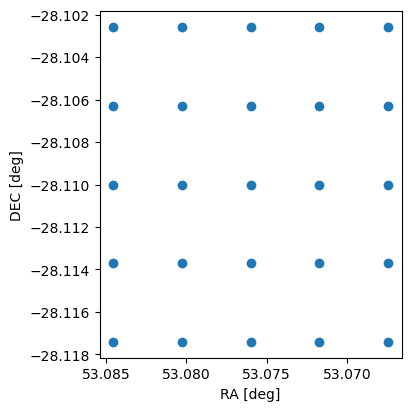

In [47]:
width_arcmin = 1
num_side = 5

inj_radec = inj.make_grid(ra_cen, dec_cen, width_arcmin, num_side)

## Visit Image Injection

In [48]:
dataset_refs = btl.get_visit_dataset_refs(ra_cen, dec_cen, band)
print(len(dataset_refs))
print(dataset_refs[0])

148
visit_image@{instrument: 'LSSTComCam', detector: 0, visit: 2024110800245, band: 'i', day_obs: 20241108, physical_filter: 'i_06'} [sc=ExposureF] (run=LSSTComCam/runs/DRP/DP1/DM-53601 id=019b1941-8acf-7980-8487-d82d7c24a5af)


Select one visit. 

In [ ]:
visit_index = 0 
visit_image = btl.get_visit_image(dataset_refs, visit_index)
visit_rotation_angle = tl.get_visit_rotation_angle(visit_image)
print(visit_rotation_angle, "deg")

In [ ]:
dataId = dataset_refs[visit_index].dataId
tag = f"visit_{dataId['visit']}_{dataId['detector']}"

### Choose a stamp (and rotate)

In [ ]:
system_index = 1
time_index = 4
stamp_folder = tl.STAMP_FOLDER

Rotate the stamp before injecting into the visit image.

In [ ]:
system_tag = "system_%d"%system_index

stamp_tag = "%s_%d"%(system_tag, time_index)
wcs_stamp_filename = "%s/%s_wcs.fits"%(stamp_folder, stamp_tag)
stp.make_rotated_stamp(visit_rotation_angle, wcs_stamp_filename)

coadd_stamp_tag = "%s_coadd"%system_tag
wcs_coadd_stamp_filename = "%s/%s_wcs.fits"%(stamp_folder, coadd_stamp_tag)

### Inject the (rotated) stamp to a visit image

Inject onto the grid.

In [ ]:
stamp_mag = fits.getval(wcs_stamp_filename, "total_mag")
print("stamp_mag: ", stamp_mag)

stamp_rot_filename = wcs_stamp_filename.replace(".fits", "_rot.fits")
stamp_filename = stamp_rot_filename 

inj_catalog_visit = inj.make_inj_catalog_visit(
                                visit_image, 
                                stamp_mag, 
                                stamp_filename, 
                                inj_radec
                            )

injected_visit_image, injected_visit_catalog = inj.visit_inject_stamp(visit_image, inj_catalog_visit)

In [ ]:
#injected_visit_catalog

In [ ]:
#tl.save_pickle(tag, visit_image, tl.FIG_FOLDER)
visit_image.writeFits("%s/%s.fits"%(tl.FIG_FOLDER, tag))

#tl.save_pickle("injected_" + tag, injected_visit_image, tl.FIG_FOLDER)
injected_visit_image.writeFits("%s/%s.fits"%(tl.FIG_FOLDER, "injected_" + tag))

### Check the image with cutout

Make a cutout at the central region.

In [ ]:
vis.plot_dual(visit_image, injected_visit_image, inj_radec, image_type="visit")

## Template injection

In [ ]:
dataset_refs = btl.get_template_dataset_refs(ra_cen, dec_cen, band)
print(len(dataset_refs))
print(dataset_refs[0])

Select one template.

In [ ]:
template_index = 0 
template_image = btl.get_template_image(dataset_refs, template_index)

In [ ]:
dataId = dataset_refs[template_index].dataId
tag = f"template_{dataId['tract']}_{dataId['patch']}_{dataId['band']}"

Follow similar procedure to the visit images, but note coadd patches do not need the rotation.

### Inject the (unrotated) stamp to a template image

Inject onto the grid.

In [ ]:
stamp_mag = fits.getval(wcs_coadd_stamp_filename, "total_mag")
print("stamp_mag: ", stamp_mag)

stamp_filename = wcs_coadd_stamp_filename

inj_catalog_template, x_arr, y_arr = inj.make_inj_catalog_template(
                                        template_image, 
                                        stamp_mag, 
                                        stamp_filename, 
                                        inj_radec
                                    )

injected_template_image, injected_template_catalog = inj.template_inject_stamp(template_image, inj_catalog_template)

In [ ]:
#injected_template_catalog

In [ ]:
#tl.save_pickle(tag, template_image, tl.FIG_FOLDER)
template_image.writeFits("%s/%s.fits"%(tl.FIG_FOLDER, tag))

#tl.save_pickle("injected_" + tag, injected_template_image, tl.FIG_FOLDER)
injected_template_image.writeFits("%s/%s.fits"%(tl.FIG_FOLDER, "injected_" + tag))

### Check the image with cutout

Make a cutout at the central region.

In [ ]:
vis.plot_dual(template_image, injected_template_image, inj_radec, image_type="template")